In [ ]:
pip install rouge transformers summa sumy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import re
import math

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.cluster import Birch
from transformers import BertTokenizer
from google.colab import drive
from rouge import Rouge

SEQUENCE_LENGTH = 250

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv('drive/MyDrive/btech_capstone/data.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [ ]:
articles = df.iloc[:, 0].values
abstracts = df.iloc[:, 1].values

In [ ]:
def preprocess(text):
    # Removing HTML tags
    text = re.sub('<.*?>', ' ', text)
    
    # Removing references ([1, 2])
    text = re.sub('\[.*?\]', ' ', text)
    
    # Removing everything inside round brackets
    text = re.sub('\(.*?\)', ' ', text)
    
    # Removing everything except alphanumeric characters and fullstop
    text = re.sub('[^A-Za-z0-9\.\%\']', ' ', text)
    
    # Removing whitespaces
    text = re.sub(' +', ' ', text)
    
    # splitting text into seperate sentences
    sentences = text.split('.')
    
    for i, sentence in enumerate(sentences):
        temp = [token for token in sentence.split() if token not in STOP_WORDS]
        sentences[i] = ' '.join(word for word in temp)

    return sentences
    

def filter_sentences(sentences):
  filtered_sentences = []
  for sentence in sentences:
    sentence_length = len(sentence.split())
    if sentence_length > 5:
      filtered_sentences.append(sentence)
  
  return filtered_sentences

In [ ]:
# preprocess then filter_sentences
final_texts = articles[:500]
final_summaries = abstracts[:500]

preprocessed_texts = []
preprocessed_summaries = []

for text in final_texts:
  temp = filter_sentences(preprocess(text))
  preprocessed_texts.append(temp)

for text in final_summaries:
  temp = filter_sentences(preprocess(text))
  preprocessed_summaries.append(temp)

## Checking the average compression rate in the sentences

In [ ]:
sum_comp_rates = 0

for i in range(500):
  sum_comp_rates += (len(preprocessed_summaries[i]) / len(preprocessed_texts[i]))

print('The average compression rate is {}'.format(sum_comp_rates/500))

The average compression rate is 0.12077654053553157


## Embeddings

In [ ]:
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

In [ ]:
def get_embeddings(sentences):
  sentence_embeddings = []
  for sentence in sentences:
    temp = tokenizer.tokenize(sentence)

    # Adding [CLS] and [SEP] tokens to the end of tokenized texts
    temp = ['[CLS]'] + temp + ['[SEP]']

    if (len(temp) < SEQUENCE_LENGTH):
      temp = temp + (['[PAD]']*(SEQUENCE_LENGTH - len(temp)))
    else:
      temp = temp[:SEQUENCE_LENGTH]
    
    embedded_sentence = tokenizer.convert_tokens_to_ids(temp)
    sentence_embeddings.append(embedded_sentence)

  return sentence_embeddings

In [ ]:
embedded_texts = []
embedded_summaries = []

for text in preprocessed_texts:
  temp = get_embeddings(text)
  embedded_texts.append(temp)

for summary in preprocessed_summaries:
  temp = get_embeddings(summary)
  embedded_summaries.append(temp)

In [ ]:
# Creating columns and subcolumns
def add_top_column(df, top_col, inplace=False):
    if not inplace:
        df = df.copy()
    
    df.columns = pd.MultiIndex.from_product([[top_col], df.columns])
    return df

In [ ]:
def get_summary(selected_article, preprocessed_text, preprocessed_summary, compression):
  
  cluster_scores = {
      'Rouge 1': [],
      'Rouge 2': [],
      'Rouge L': []
  }

  for num_cluster in range(2, 13):
   
    birch_model = Birch(threshold=0.03, n_clusters=num_cluster)
    birch_model.fit(selected_article)

    # assign each data point to a cluster
    birch_result = birch_model.predict(selected_article)
 
    clusters_embeddings = [[] for i in range(num_cluster)]
    clusters_sentences = [[] for i in range(num_cluster)]
  
    for idx, (embedding, text) in enumerate(zip(selected_article, preprocessed_text)):
      cluster_selected = birch_result[idx]
      clusters_embeddings[cluster_selected].append(embedding)
      clusters_sentences[cluster_selected].append(text)

    COMPRESSION_RATE = compression

    # Number of sentences to be selected from each cluster
    cluster_sentence_numbers = []

    for cluster in clusters_embeddings:
      cluster_size = len(cluster)
      temp = math.floor(cluster_size * COMPRESSION_RATE)
      cluster_sentence_numbers.append(temp)


    # Now we have the number of sentences that have to be selected from each cluster
    # Now we have to calculate the informativeness score for each sentences. It will be a list of lists, 
    # where the length will be equal to the number of clusters 
    # Initializing the informativeness score list

    informativeness_scores = []
    for i in range(num_cluster):
      temp = [0] * len(clusters_embeddings[i])
      informativeness_scores.append(temp)
    
    
    for i in range(num_cluster):

      cluster = clusters_embeddings[i]
      CLUSTER_SIZE = len(cluster)

      for j in range(len(cluster)):
         
        selected_text = np.array(cluster[j])
        summation_euclidean = 0 

        for k in range(len(cluster)):
          other_text = np.array(cluster[k])
          dist = np.linalg.norm(selected_text - other_text)
          summation_euclidean += dist

        i_score = summation_euclidean / CLUSTER_SIZE
        i_score = 1 / i_score
      
        informativeness_scores[i][j] = i_score
    
    # Getting the summary 
    summary = []
    for i in range(num_cluster):
      sorted_cluster = [x for _, x in sorted(zip(informativeness_scores[i], clusters_sentences[i]))]
      summary.append(sorted_cluster[:cluster_sentence_numbers[i]])
    
    flat_summary = [sentence for sublist in summary for sentence in sublist]

    # Getting Rouge Score
    rouge = Rouge()

    in_sentence = ' '.join([str(item) for item in flat_summary])
    out_sentence = ' '.join([str(item) for item in preprocessed_summary])
    
    scores = rouge.get_scores(in_sentence, out_sentence)
    cluster_scores['Rouge 1'].append(scores[0]['rouge-1']['r'])
    cluster_scores['Rouge 2'].append(scores[0]['rouge-2']['r'])
    cluster_scores['Rouge L'].append(scores[0]['rouge-l']['r'])
  
  cluster_df = pd.DataFrame(cluster_scores, index = [*range(2, 13, 1)])
  return cluster_df, flat_summary

In [ ]:
rouge_results, model_summary = get_summary(embedded_texts[1], preprocessed_texts[1], preprocessed_summaries[1], 0.2)

In [ ]:
rouge_results

,Rouge 1,Rouge 2,Rouge L
2,0.609756,0.163265,0.341463
3,0.609756,0.163265,0.365854
4,0.585366,0.163265,0.292683
5,0.585366,0.163265,0.390244
6,0.536585,0.142857,0.414634
7,0.512195,0.122449,0.390244
8,0.512195,0.142857,0.341463
9,0.512195,0.142857,0.292683
10,0.439024,0.122449,0.292683
11,0.487805,0.163265,0.268293


In [ ]:
final_texts[1]

'small non - coding rnas are transcribed into mrna but remain untranslated in eukaryotic cells . they include sirna ( small interfering rna ) , mirna ( microrna ) , pirna ( piwi - interacting rna ) and snorna ( small nucleolar rna ) . mirnas are a class of multifunctional singled - stranded small rna which are ~20  nt in length and regulate the stability or translational efficiency of targeted messenger rna depending on the base - pairing complementarity between the mirna and its target mrna [ 1 , 2 ] . although over 1,000 mirna sequences have been identified from the tissues or cells of human origin and other species , as many as 1,000 to 10,000 mirnas per genome have been predicted [ 3 , 4 ] . mirnas regulate a broad range of biological processes including timing of development , cell cycle progression , stem cell self - renewal , differentiation , cancer initiation , cancer cell proliferation , metastasis and apoptosis [ 511 ] . cancer is caused by multiple processes including uncon

In [ ]:
model_summary

['cell surface markers cd44 cd24 cd133 epithelial specific antigen aldehyde dehydrogenase 1 frequently isolate enrich cscs',
 'summarize recent literature research progress mechanism mirnas regulate breast cancer cell cycle cellular proliferation inhibit mitochondria biogenesis',
 'dysregulated expression mirnas implicated components non coding genome oncogenes tumor suppressors breast cancer',
 'dysregulated mirna expression observed cancer associated fibroblasts systemic circulation',
 'high throughput deep sequencing identified group small rnas matching pirna sequences human breast cancer tissues breast cancer cell lines',
 'cancer stem cells characterized self renewal capacity ability differentiate non tumorigenic cell progeny ability seed tumors transplanted animal hosts',
 'zhang colleagues analyzed 283 human mirna genes 55 human breast primary tumors 18 human breast cancer cell lines array based comparative genomic hybridization',
 'circulating mirnas potential serve novel diagn

In [ ]:
all_results = []

for comp in [0.1, 0.12, 0.14, 0.16, 0.18, 0.2]:
  rouge_results, _ = get_summary(embedded_texts[1], preprocessed_texts[1], preprocessed_summaries[1], comp)
  all_results.append(rouge_results)

In [ ]:
new_df1 = add_top_column(all_results[0], "0.1")
new_df2 = add_top_column(all_results[1], "0.12")
new_df3 = add_top_column(all_results[2], "0.14")
new_df4 = add_top_column(all_results[3], "0.16")
new_df5 = add_top_column(all_results[4], "0.18")
new_df6 = add_top_column(all_results[5], "0.2")

In [ ]:
rouge_results = pd.concat([new_df1, new_df2, new_df3, new_df4, new_df5, new_df6], axis=1)

In [ ]:
rouge_results

0.1                          0.12                          0.14  \
     Rouge 1   Rouge 2   Rouge L   Rouge 1   Rouge 2   Rouge L   Rouge 1   
2   0.487805  0.142857  0.292683  0.487805  0.142857  0.292683  0.487805   
3   0.487805  0.142857  0.243902  0.487805  0.142857  0.243902  0.487805   
4   0.390244  0.122449  0.292683  0.390244  0.122449  0.292683  0.390244   
5   0.463415  0.102041  0.341463  0.487805  0.122449  0.243902  0.512195   
6   0.463415  0.102041  0.341463  0.487805  0.122449  0.243902  0.512195   
7   0.414634  0.122449  0.243902  0.414634  0.122449  0.243902  0.439024   
8   0.390244  0.122449  0.268293  0.414634  0.142857  0.268293  0.439024   
9   0.365854  0.102041  0.243902  0.390244  0.122449  0.243902  0.414634   
10  0.195122  0.061224  0.195122  0.292683  0.081633  0.243902  0.292683   
11  0.195122  0.061224  0.195122  0.243902  0.081633  0.195122  0.268293   
12  0.195122  0.061224  0.195122  0.243902  0.081633  0.195122  0.268293   

                            0.16                          0.18            \
     Rouge 2   Rouge L   Rouge 1   Rouge 2   Rouge L   Rouge 1   Rouge 2   
2   0.142857  0.292683  0.512195  0.142857  0.341463  0.585366  0.142857   
3   0.142857  0.317073  0.512195  0.142857  0.292683  0.609756  0.142857   
4   0.122449  0.268293  0.512195  0.142857  0.268293  0.585366  0.142857   
5   0.122449  0.365854  0.585366  0.163265  0.268293  0.585366  0.163265   
6   0.122449  0.365854  0.536585  0.142857  0.317073  0.536585  0.142857   
7   0.122449  0.243902  0.512195  0.122449  0.365854  0.512195  0.122449   
8   0.142857  0.317073  0.439024  0.142857  0.317073  0.439024  0.142857   
9   0.122449  0.268293  0.414634  0.122449  0.268293  0.439024  0.142857   
10  0.081633  0.243902  0.292683  0.081633  0.243902  0.365854  0.102041   
11  0.081633  0.219512  0.341463  0.122449  0.195122  0.390244  0.142857   
12  0.081633  0.219512  0.268293  0.081633  0.219512  0.341463  0.102041   

                   0.2                      
     Rouge L   Rouge 1   Rouge 2   Rouge L  
2   0.341463  0.609756  0.163265  0.341463  
3   0.341463  0.609756  0.163265  0.365854  
4   0.268293  0.585366  0.163265  0.292683  
5   0.292683  0.585366  0.163265  0.390244  
6   0.292683  0.536585  0.142857  0.414634  
7   0.268293  0.512195  0.122449  0.390244  
8   0.317073  0.512195  0.142857  0.341463  
9   0.268293  0.512195  0.142857  0.292683  
10  0.268293  0.439024  0.122449  0.292683  
11  0.268293  0.487805  0.163265  0.268293  
12  0.268293  0.487805  0.163265  0.268293

In [ ]:
import matplotlib.pyplot as plt

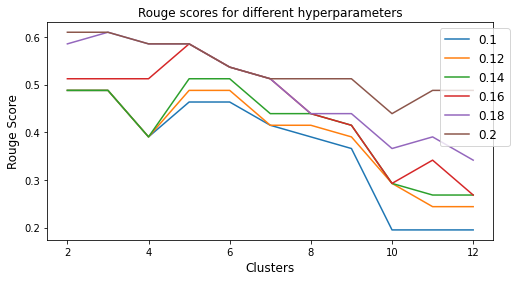

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rouge_results["0.1"]["Rouge 1"], label="0.1")
plt.plot(rouge_results["0.12"]["Rouge 1"], label="0.12")
plt.plot(rouge_results["0.14"]["Rouge 1"], label="0.14")
plt.plot(rouge_results["0.16"]["Rouge 1"], label="0.16")
plt.plot(rouge_results["0.18"]["Rouge 1"], label="0.18")
plt.plot(rouge_results["0.2"]["Rouge 1"], label="0.2")
plt.title('Rouge scores for different hyperparameters', fontsize=12)
plt.xlabel('Clusters', fontsize=12)
plt.ylabel('Rouge Score', fontsize=12)
plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.05, 1))
plt.show()


In [ ]:
SUMMARY_SENTENCE_LENGTH = math.floor(0.2 * len(preprocessed_texts[0]))

## SUMMA

In [ ]:
from summa import summarizer

In [ ]:
first_text = '. '.join([str(item) for item in model_summary])

In [ ]:
input_text = '. '.join([str(item) for item in preprocessed_texts[1]])

In [ ]:
summa_summary = summarizer.summarize(input_text, ratio=0.2)

In [ ]:
second_text = summa_summary.replace('\n', ' ')

In [ ]:
third_text = '. '.join([str(item) for item in preprocessed_summaries[1]])

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(second_text, third_text)

In [ ]:
scores

[{'rouge-1': {'f': 0.21999999674050003,
   'p': 0.13836477987421383,
   'r': 0.5365853658536586},
  'rouge-2': {'f': 0.05614034802979393,
   'p': 0.03389830508474576,
   'r': 0.16326530612244897},
  'rouge-l': {'f': 0.19999999674050004,
   'p': 0.12578616352201258,
   'r': 0.4878048780487805}}]

## LEXRANK

In [ ]:
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

In [ ]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
document = '. '.join([str(item) for item in preprocessed_texts[1]])

In [ ]:
parser = PlaintextParser.from_string(document, Tokenizer("english"))

In [ ]:
summarizer = LexRankSummarizer()

In [ ]:
lexrank_summary = summarizer(parser.document, SUMMARY_SENTENCE_LENGTH)

In [ ]:
second_text = ' '.join([str(item) for item in lexrank_summary])

In [ ]:
third_text = '. '.join([str(item) for item in preprocessed_summaries[1]])

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(second_text, third_text)

In [ ]:
scores

[{'rouge-1': {'f': 0.22641509121974016,
   'p': 0.14035087719298245,
   'r': 0.5853658536585366},
  'rouge-2': {'f': 0.054545452016712695,
   'p': 0.03202846975088968,
   'r': 0.1836734693877551},
  'rouge-l': {'f': 0.19811320442728736,
   'p': 0.12280701754385964,
   'r': 0.5121951219512195}}]

##LUHN

In [ ]:
from sumy.summarizers.luhn import LuhnSummarizer

In [ ]:
luhn_summarizer = LuhnSummarizer()

In [ ]:
luhn_summary = luhn_summarizer(parser.document, SUMMARY_SENTENCE_LENGTH)

In [ ]:
second_text = ' '.join([str(item) for item in luhn_summary])

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(second_text, third_text)

In [ ]:
scores

[{'rouge-1': {'f': 0.19917012165768497, 'p': 0.12, 'r': 0.5853658536585366},
  'rouge-2': {'f': 0.04627249137132332,
   'p': 0.026470588235294117,
   'r': 0.1836734693877551},
  'rouge-l': {'f': 0.17427385609751903, 'p': 0.105, 'r': 0.5121951219512195}}]

## LATENT SEMANTIC ANALYSIS

In [ ]:
from sumy.summarizers.lsa import LsaSummarizer

In [ ]:
lsa_summarizer = LsaSummarizer()

In [ ]:
lsa_summary = lsa_summarizer(parser.document, SUMMARY_SENTENCE_LENGTH)

In [ ]:
second_text = ' '.join([str(item) for item in lsa_summary])

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(second_text, third_text)

In [ ]:
scores

[{'rouge-1': {'f': 0.2183406084140272,
   'p': 0.13297872340425532,
   'r': 0.6097560975609756},
  'rouge-2': {'f': 0.0776699002440277,
   'p': 0.046153846153846156,
   'r': 0.24489795918367346},
  'rouge-l': {'f': 0.20960698395987876,
   'p': 0.1276595744680851,
   'r': 0.5853658536585366}}]

## Visualizing the results

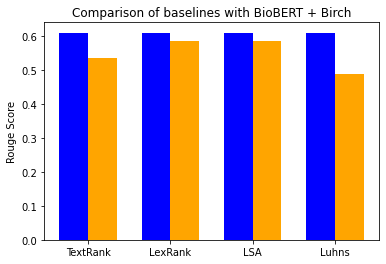

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 4
baseline_scores = (0.5365, 0.5853, 0.5853, 0.4878)
model_scores = (0.6097, 0.6097, 0.6097, 0.6097)

ind = np.arange(N)  
width = 0.35       

fig, ax = plt.subplots()
rects1 = ax.bar(ind, model_scores, width, color='blue')
rects2 = ax.bar(ind + width, baseline_scores, width, color='orange')

ax.set_ylabel('Rouge Score')
ax.set_title('Comparison of baselines with BioBERT + Birch')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('TextRank', 'LexRank', 'LSA', 'Luhns'))
plt.show()